In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

In [4]:
def vis(eddy, t, depth_lvl):
    
    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
    neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 2] == var]
    
    if len(neddy[:, 1]) > 1:
        R = np.hypot(neddy[:, 1], neddy[:, 0]) if depth_lvl == 0 else np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
        neddy = neddy[R == np.nanmin(R)]
    
    nxc, nyc = neddy[0, 1], neddy[0, 0]
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)
    
        tangent_line = slope * x + intercept
        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - tangent_line)**2)
        r_squared = 1 - (sse / sst)
    
        return slope, intercept, r_squared
    
    # Plot fits
    def extend_indices(arr, start_idx, r):
        indices = [start_idx]
        idx = start_idx
        i = 0
        while idx > 0 and not np.isnan(arr[idx - 1]):
            idx -= 1
            indices.insert(0, idx)
            if i > r:
                break
            i += 1
        idx = start_idx
        i = 0
        while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
            idx += 1
            indices.append(idx)
            if i > r:
                break
            i += 1
        return indices
    
    r = 40 # 
    indices_1 = extend_indices(u[:, njc], nic, r)
    indices_2 = extend_indices(u[nic, :], njc, r)
    u1 = u[indices_1, njc]
    v1 = v[indices_1, njc]
    u2 = u[nic, indices_2]
    v2 = v[nic, indices_2]
    xx = x[indices_1] / 1000
    yy = y[indices_2] / 1000
    
    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, r2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={r2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()
    
    # # Calculate results
    # A1, A0, r2A = fit_cubic_and_tangent(x[nic-25:nic+26]/1000, u[nic-25:nic+26, njc])
    # B1, B0, r2B = fit_cubic_and_tangent(x[nic-25:nic+26]/1000, v[nic-25:nic+26, njc])
    # C1, C0, r2C = fit_cubic_and_tangent(y[njc-25:njc+26]/1000, u[nic, njc-25:njc+26])
    # D1, D0, r2D = fit_cubic_and_tangent(y[njc-25:njc+26]/1000, v[nic, njc-25:njc+26])

    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
    
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    w = 2 * (q11 + q22)
    
    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [nyc/1000] *len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([nxc/1000] * len(yy), yy, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X/1000, Y/1000, mask.T, cmap='gray', zorder=-1)
        plt.contour(X/1000, Y/1000, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc/1000, yc/1000, color='r', marker='x', s=100, label='MOCA')
    plt.legend()


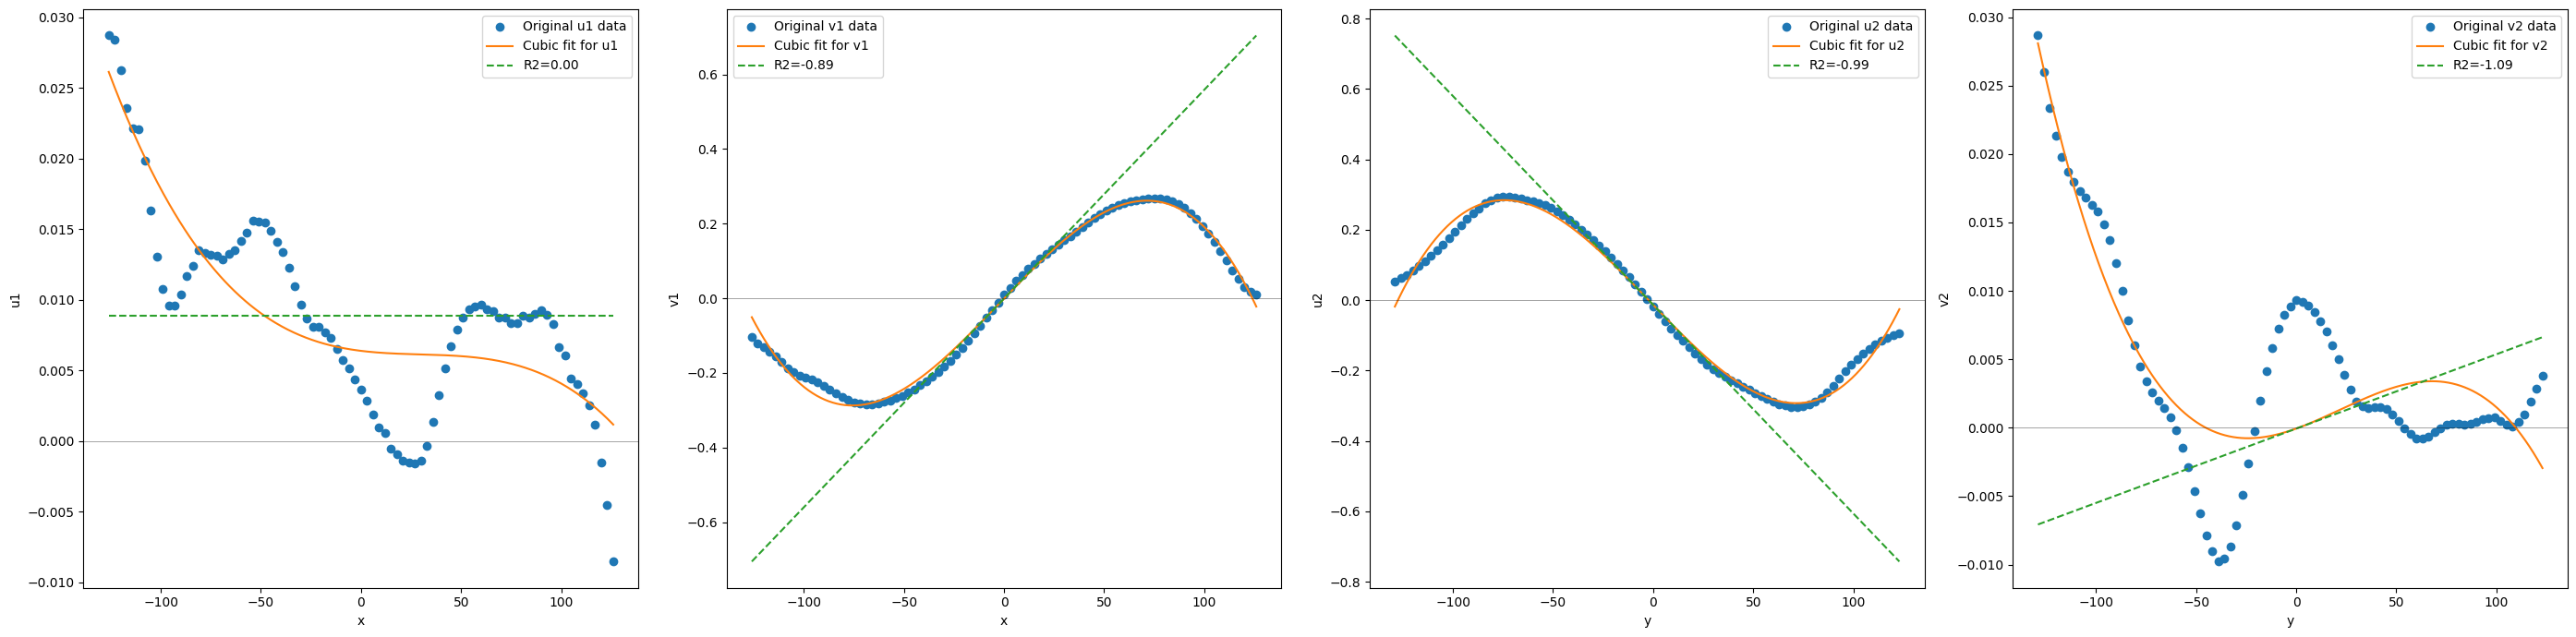

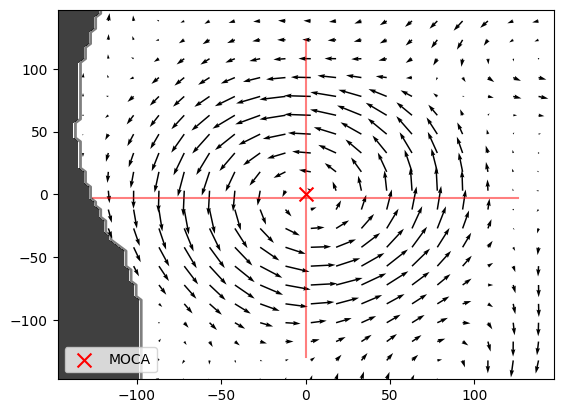

In [5]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 14, 20

vis(eddy, t, depth_lvl)

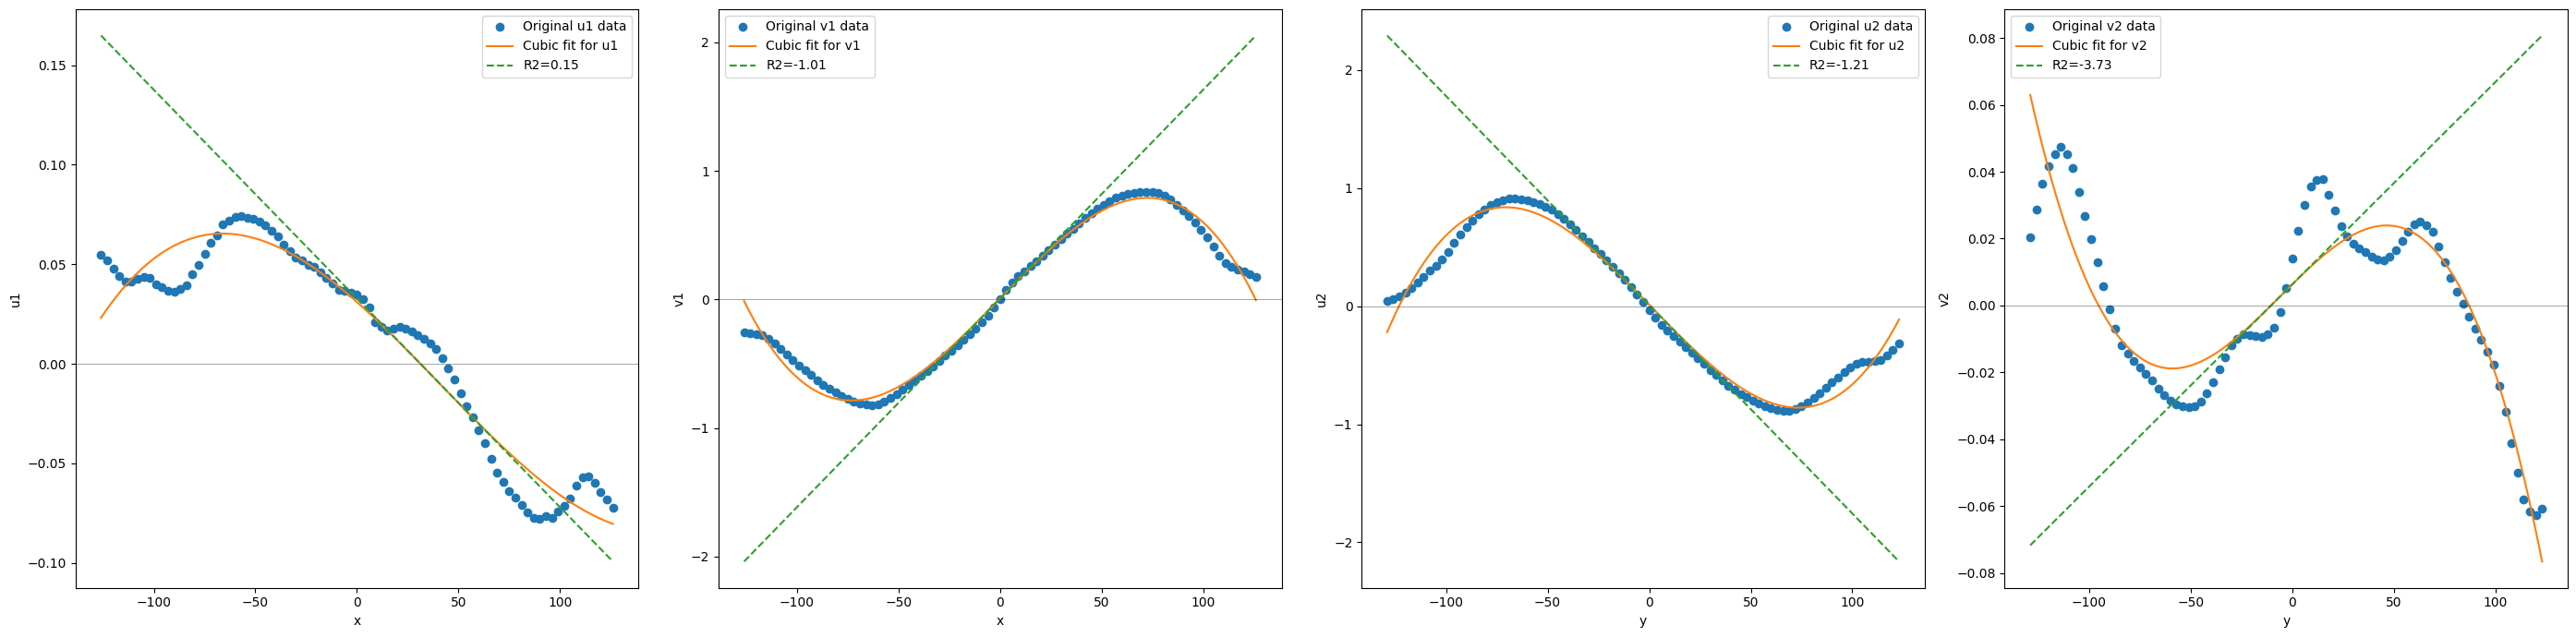

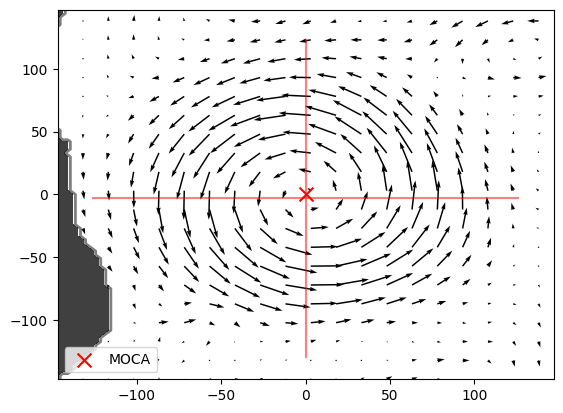

In [6]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 10

vis(eddy, t, depth_lvl)

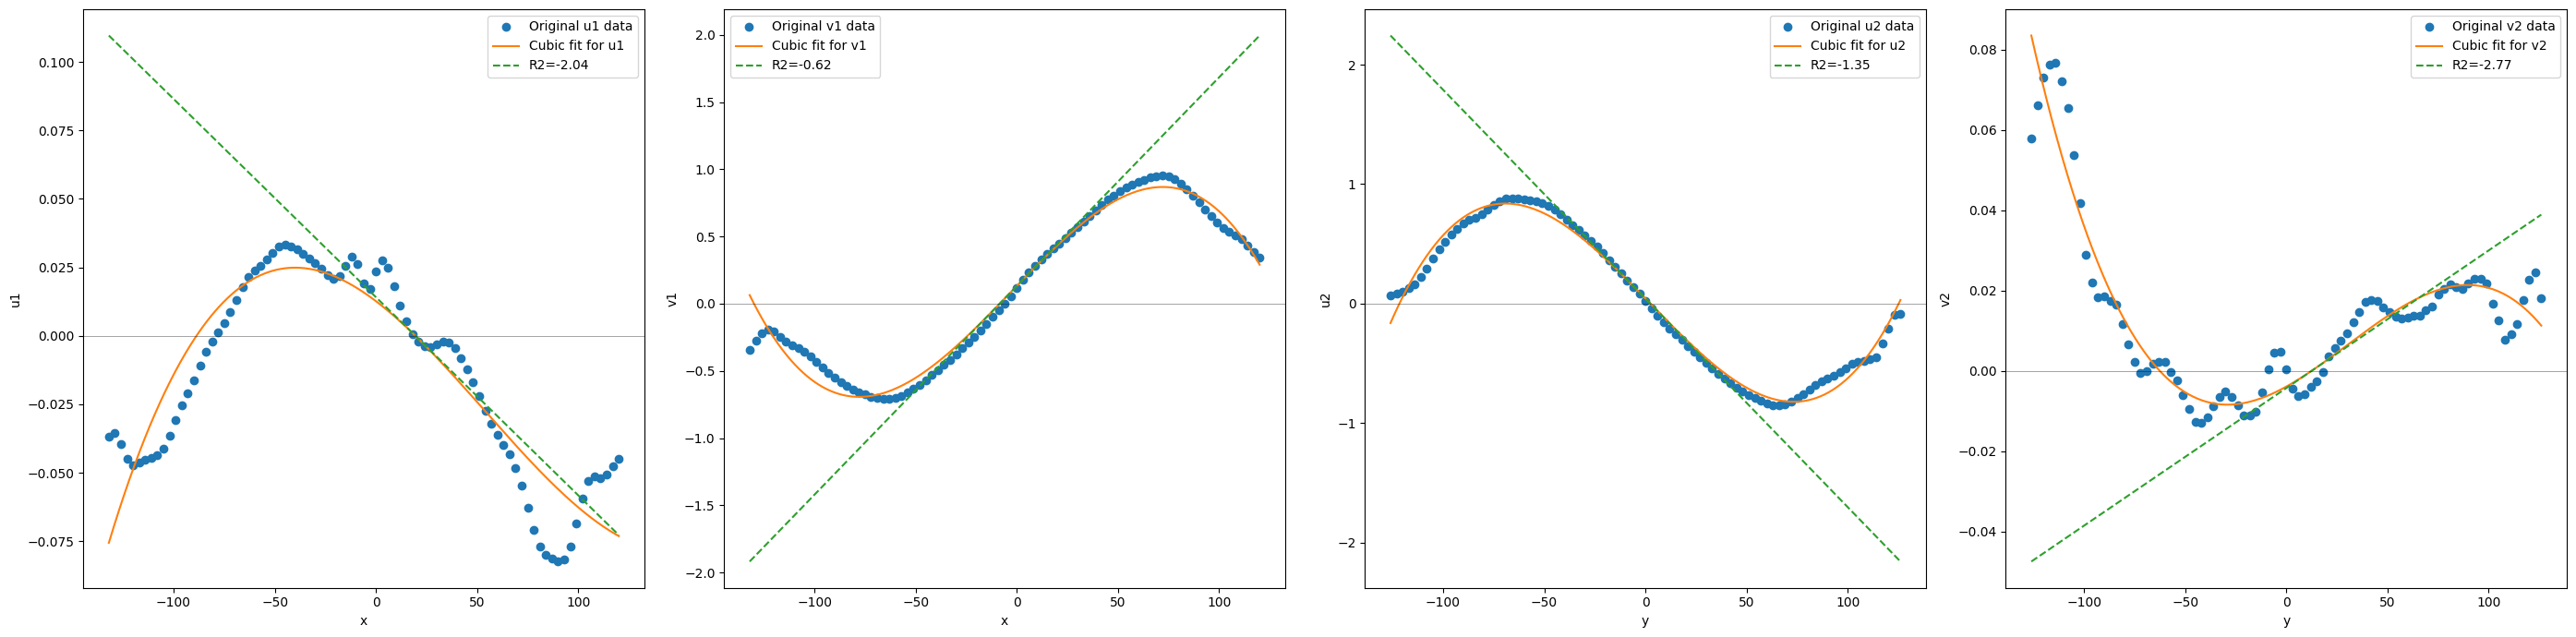

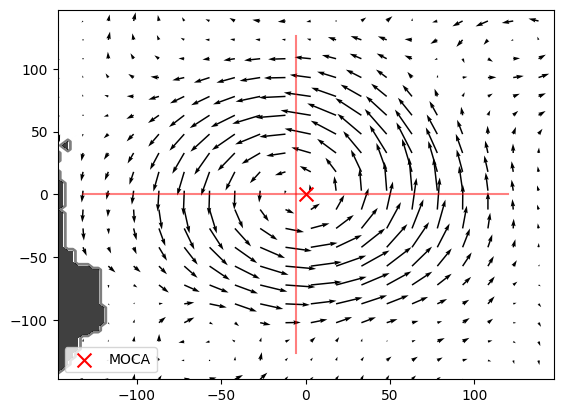

In [7]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 0

vis(eddy, t, depth_lvl)

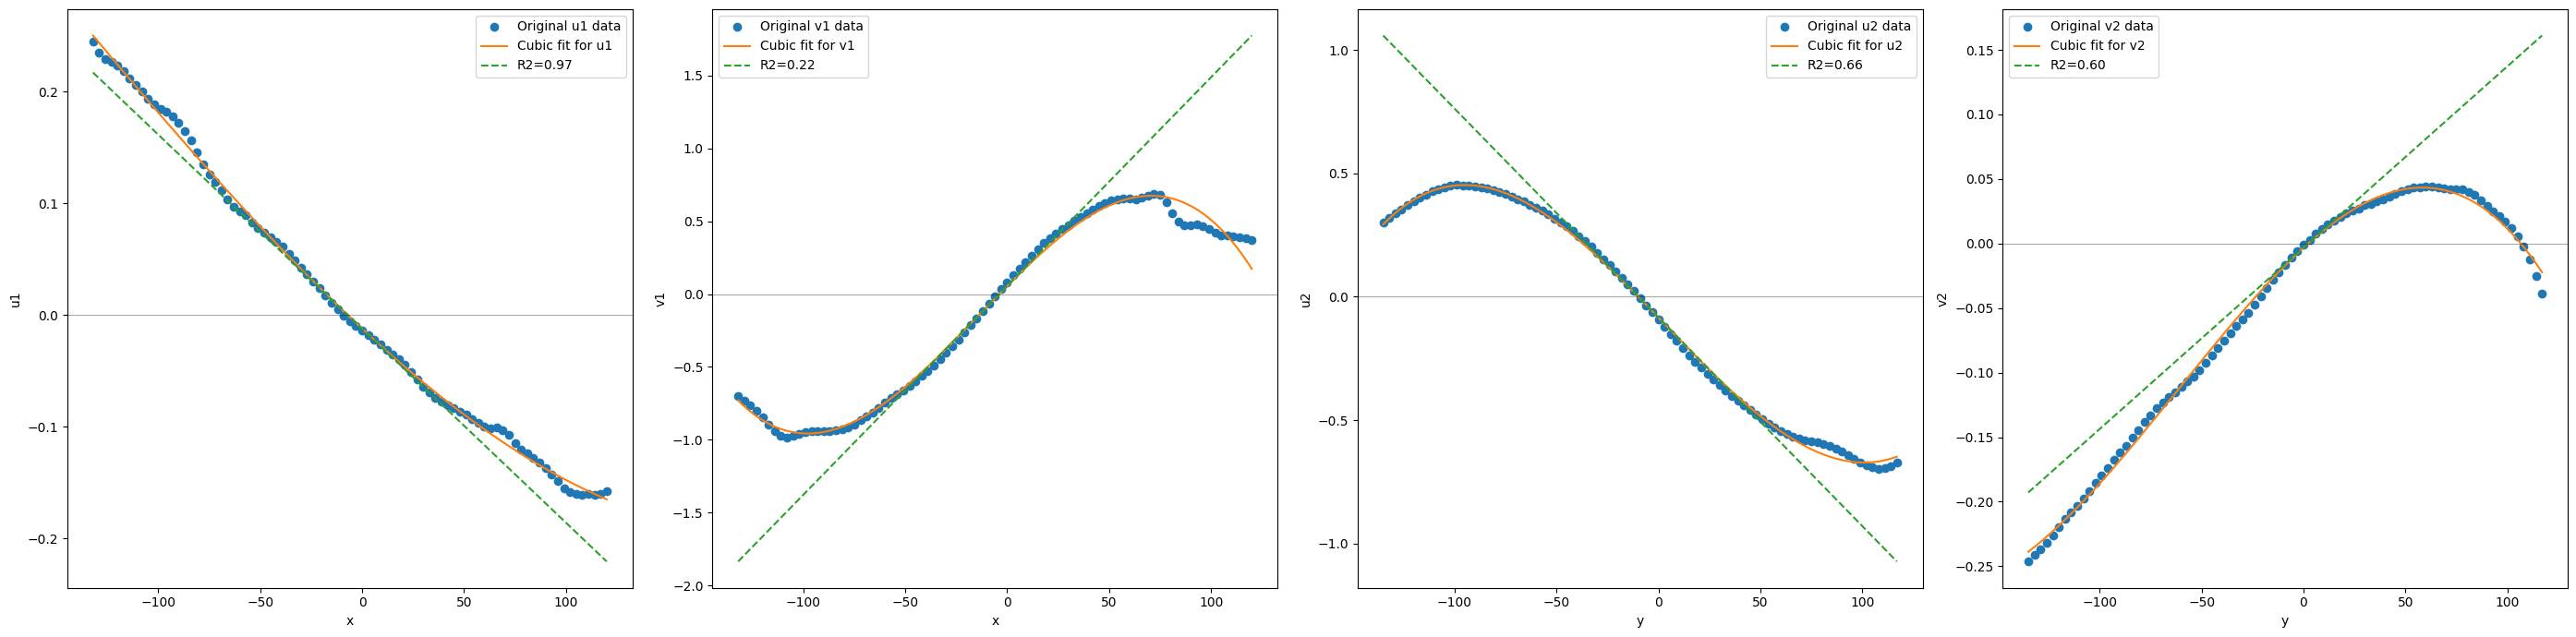

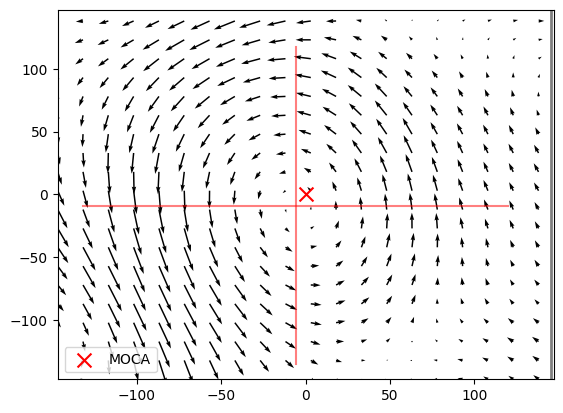

In [8]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

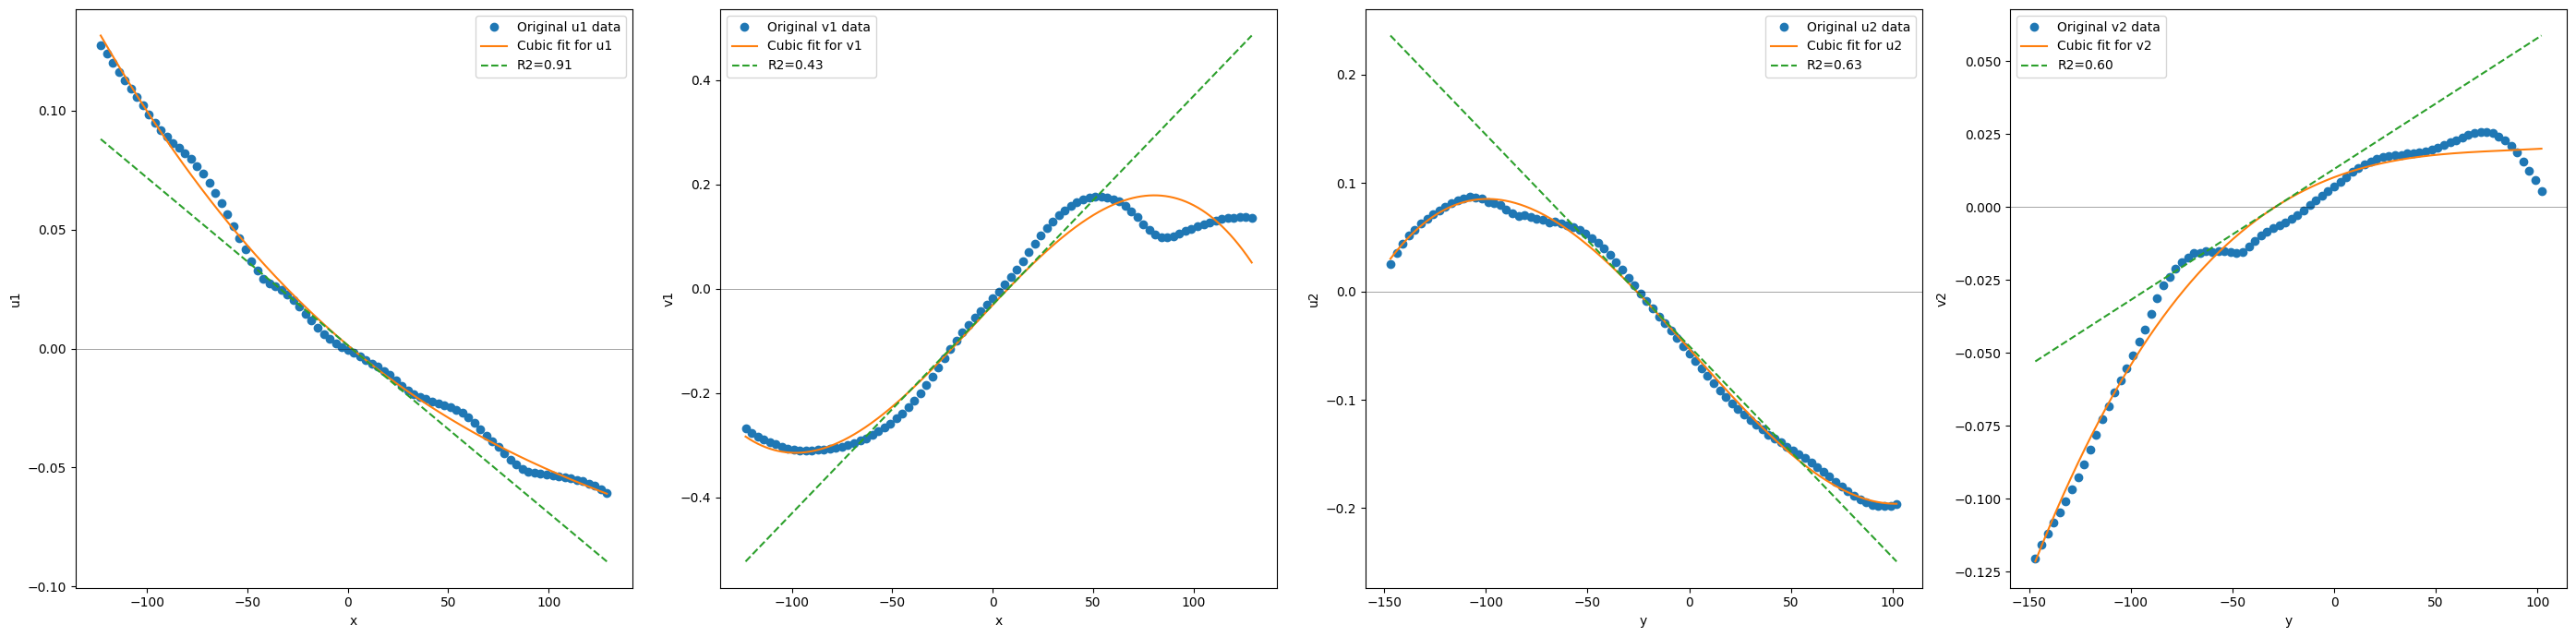

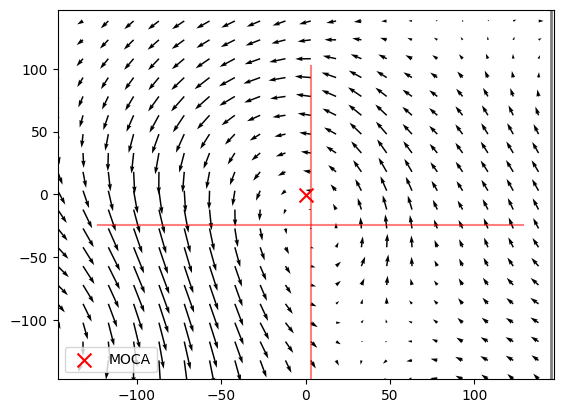

In [9]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 20

vis(eddy, t, depth_lvl)

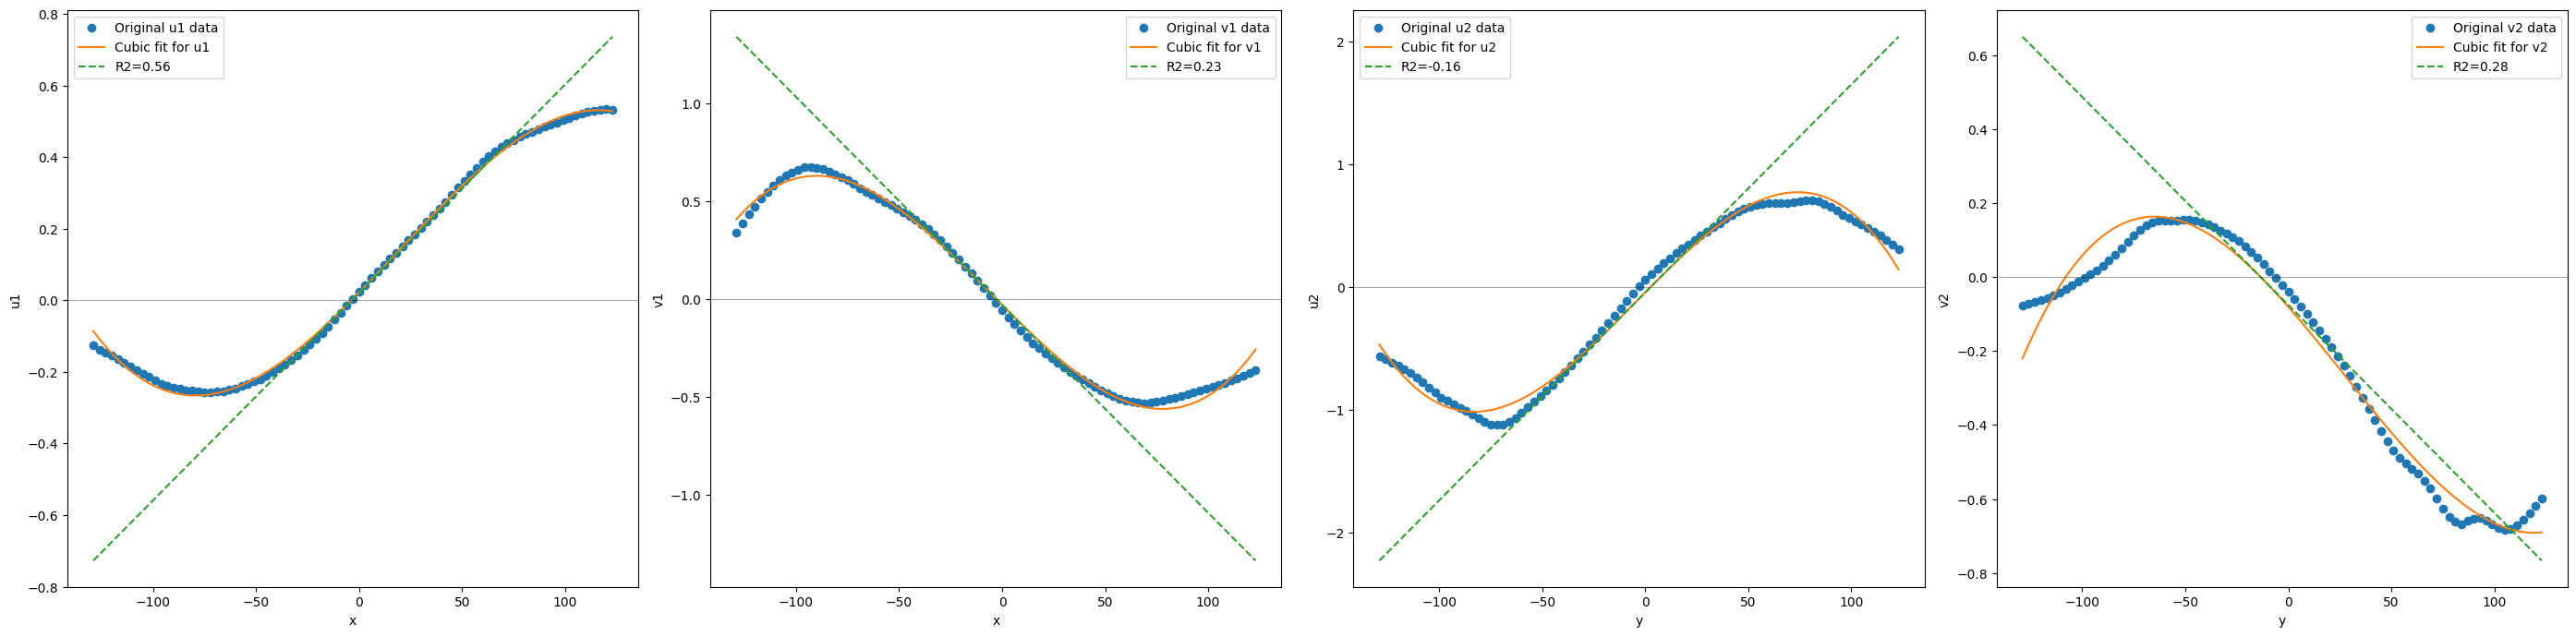

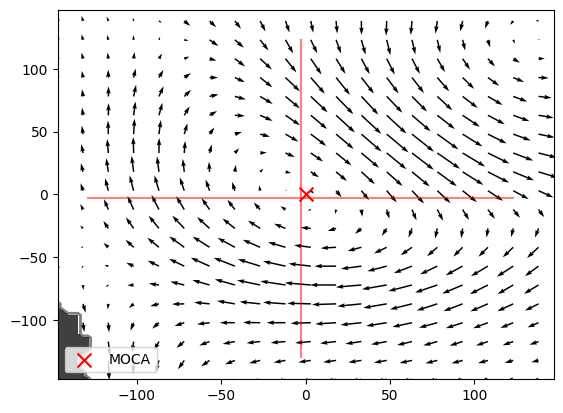

In [10]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 0, 0

vis(eddy, t, depth_lvl)

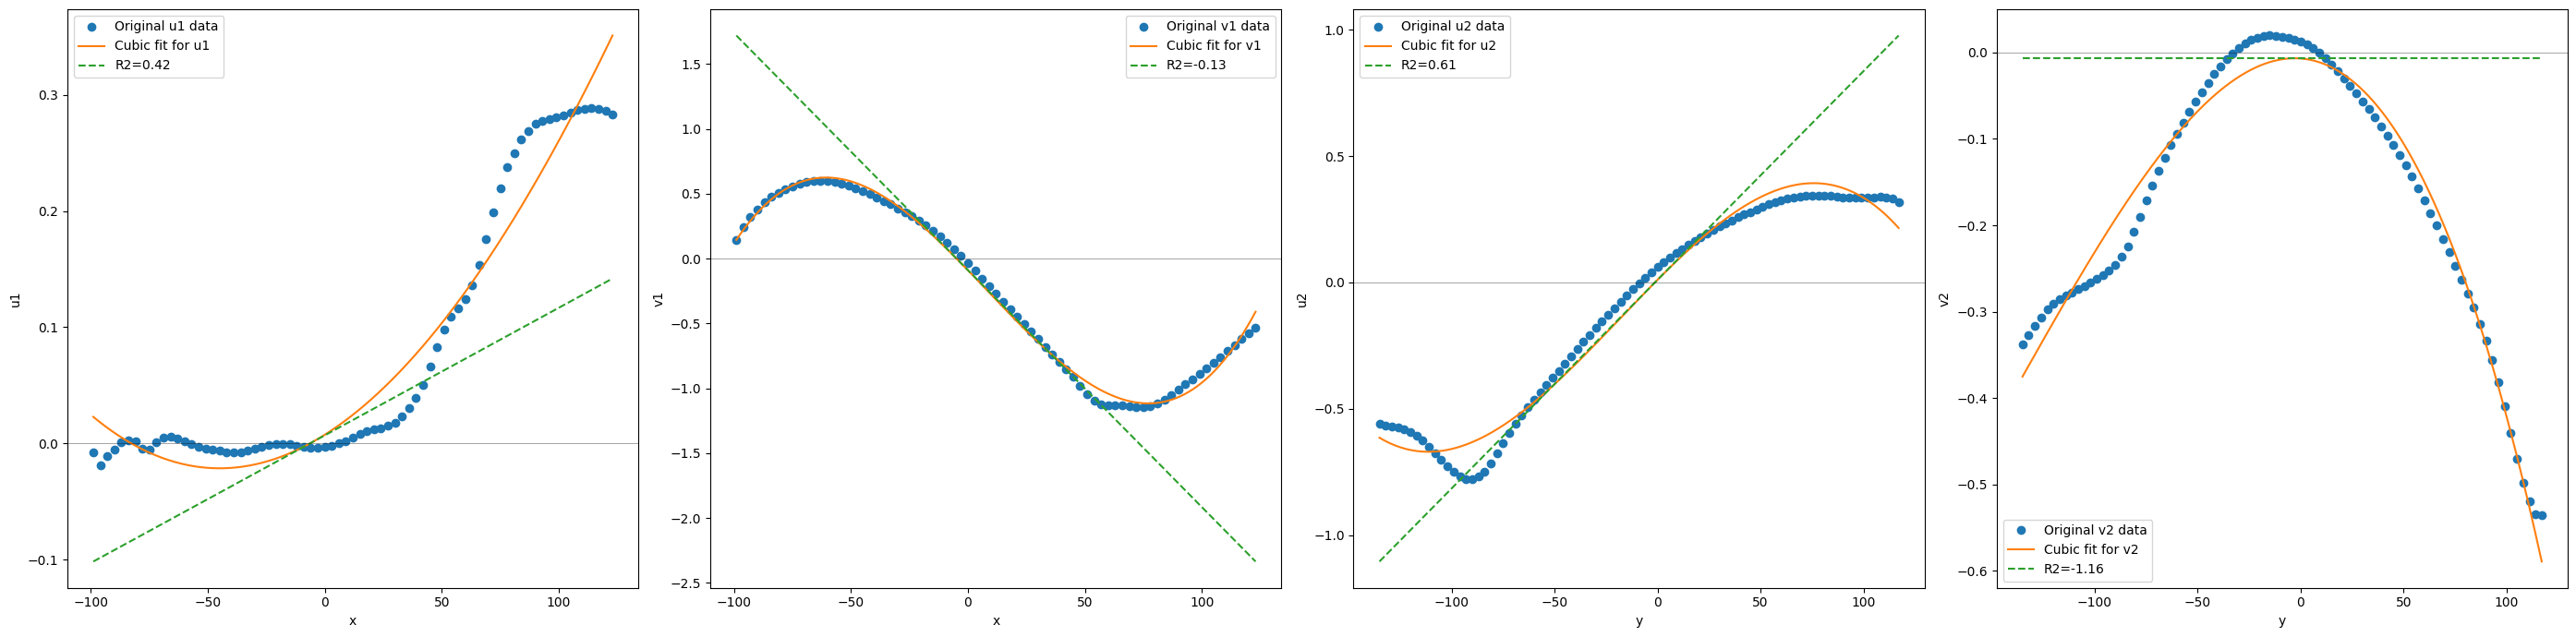

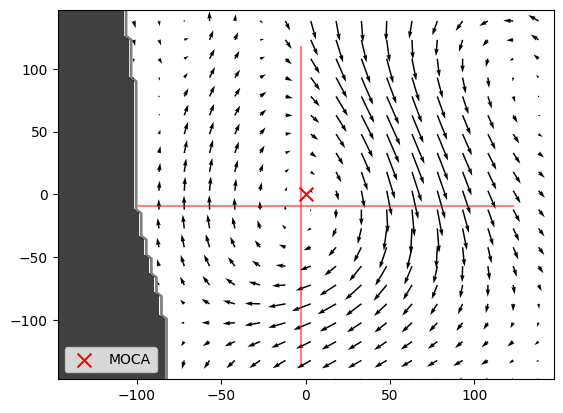

In [11]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 10, 10

vis(eddy, t, depth_lvl)

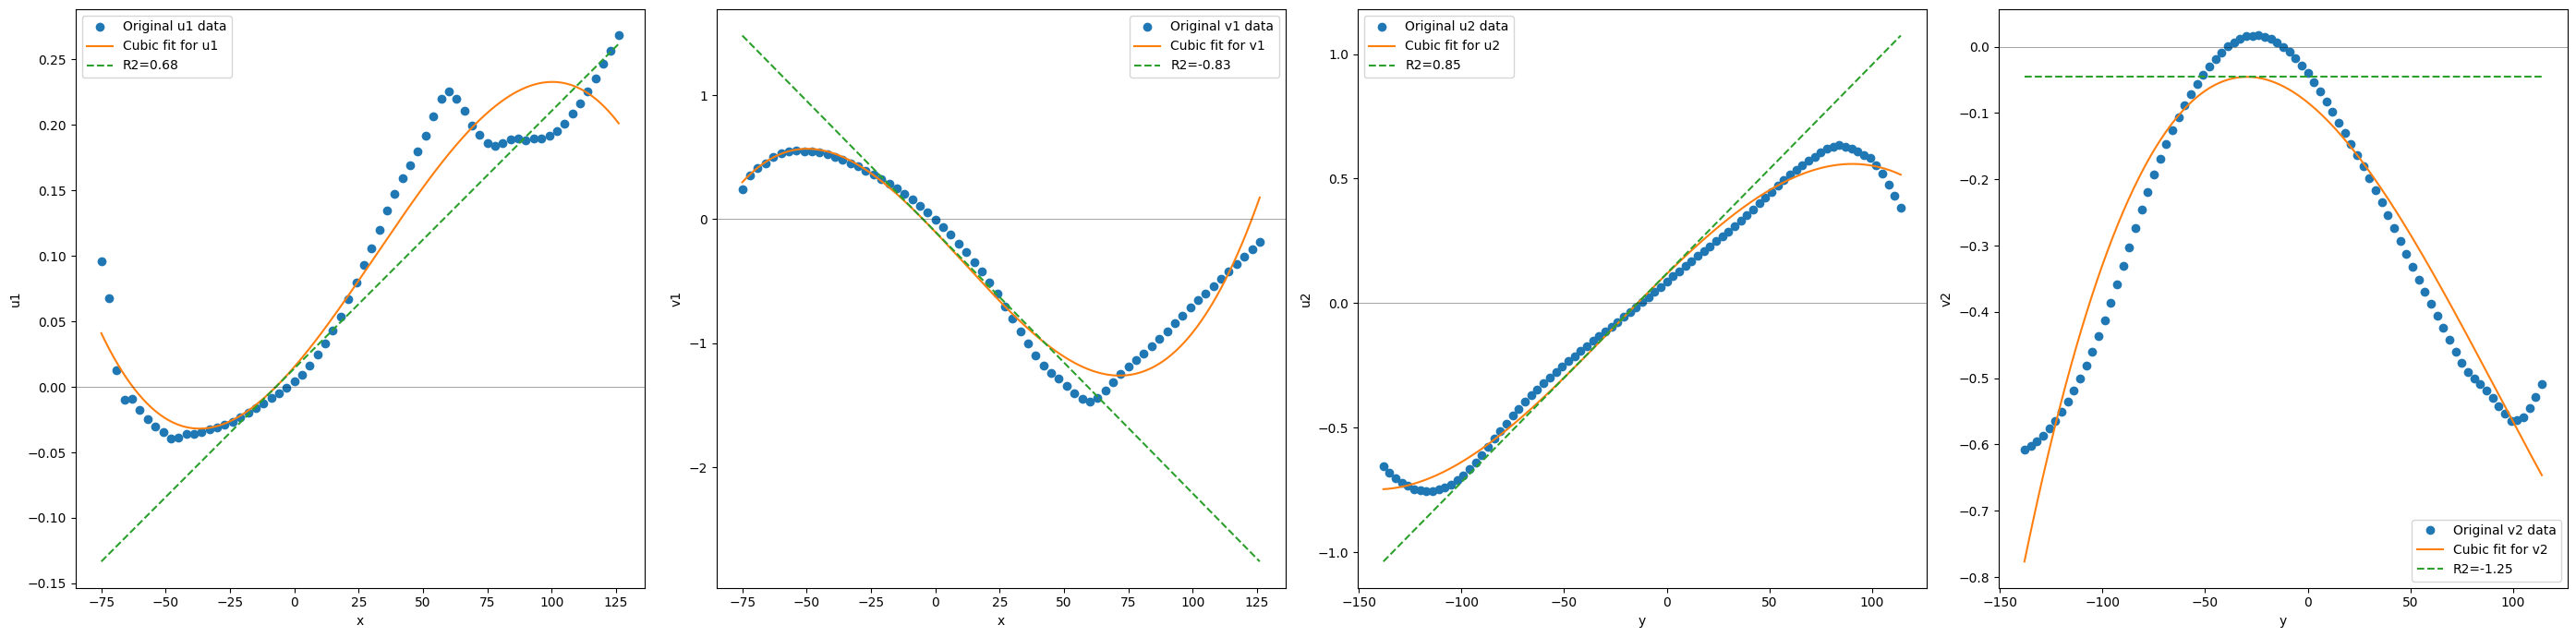

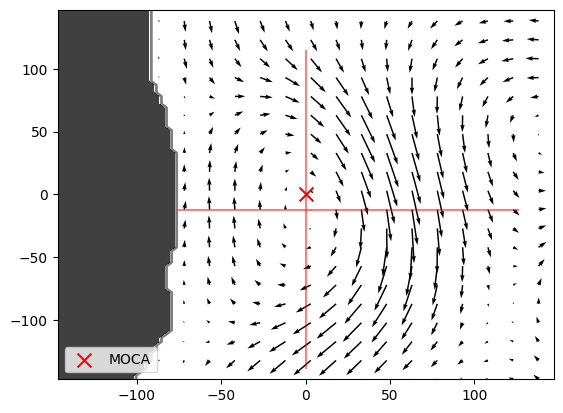

In [12]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

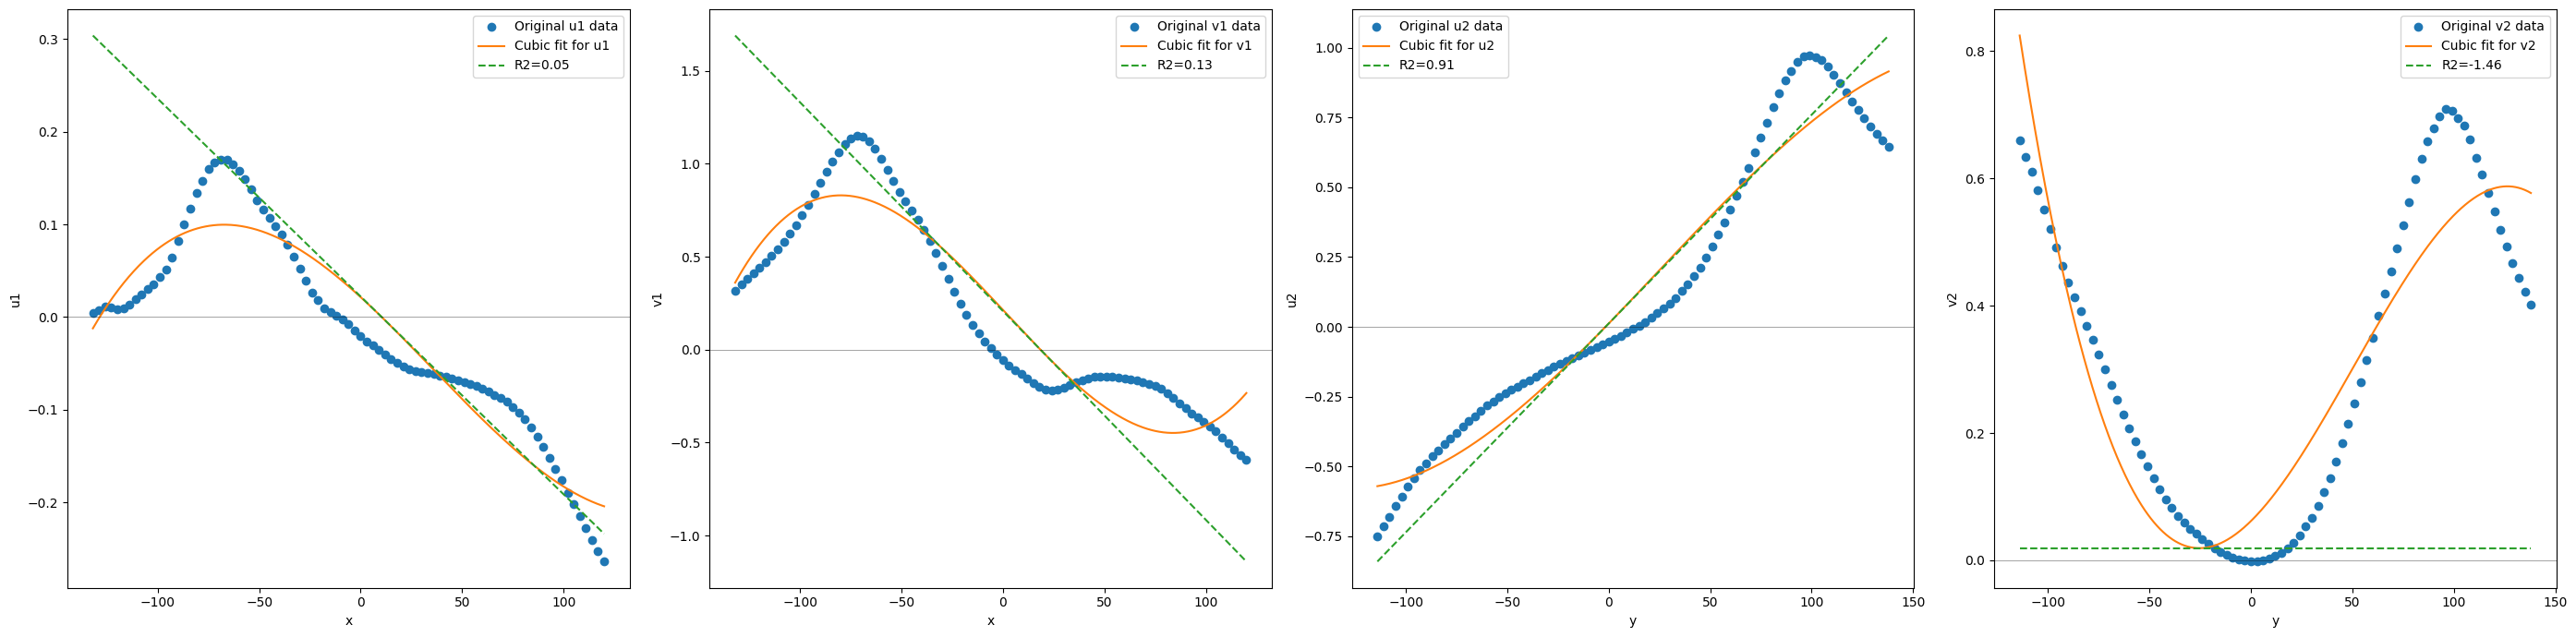

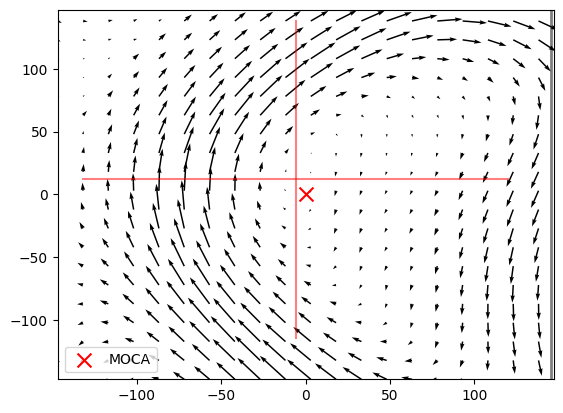

In [13]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

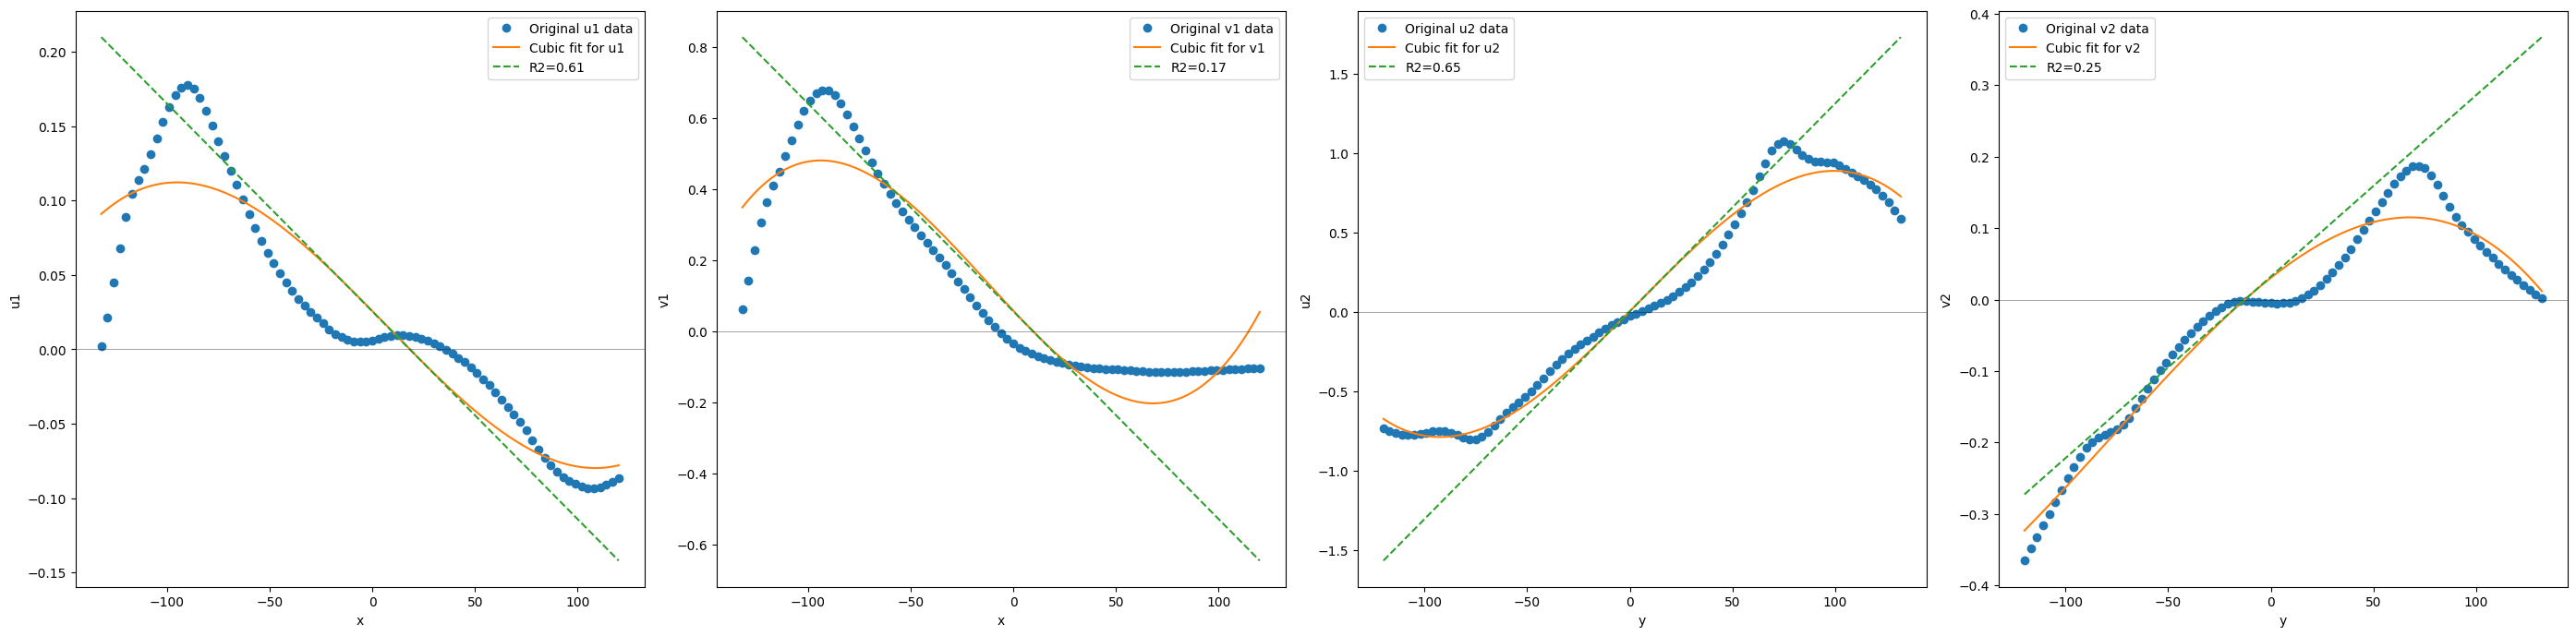

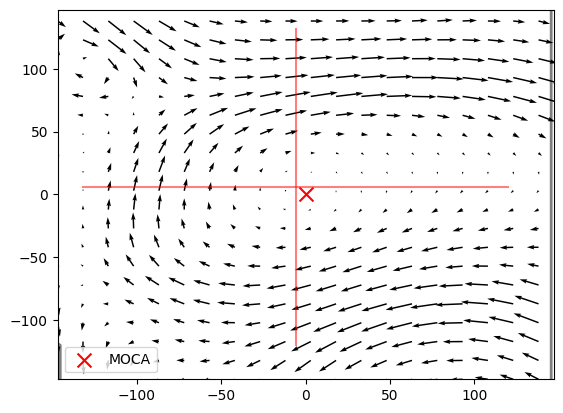

In [14]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

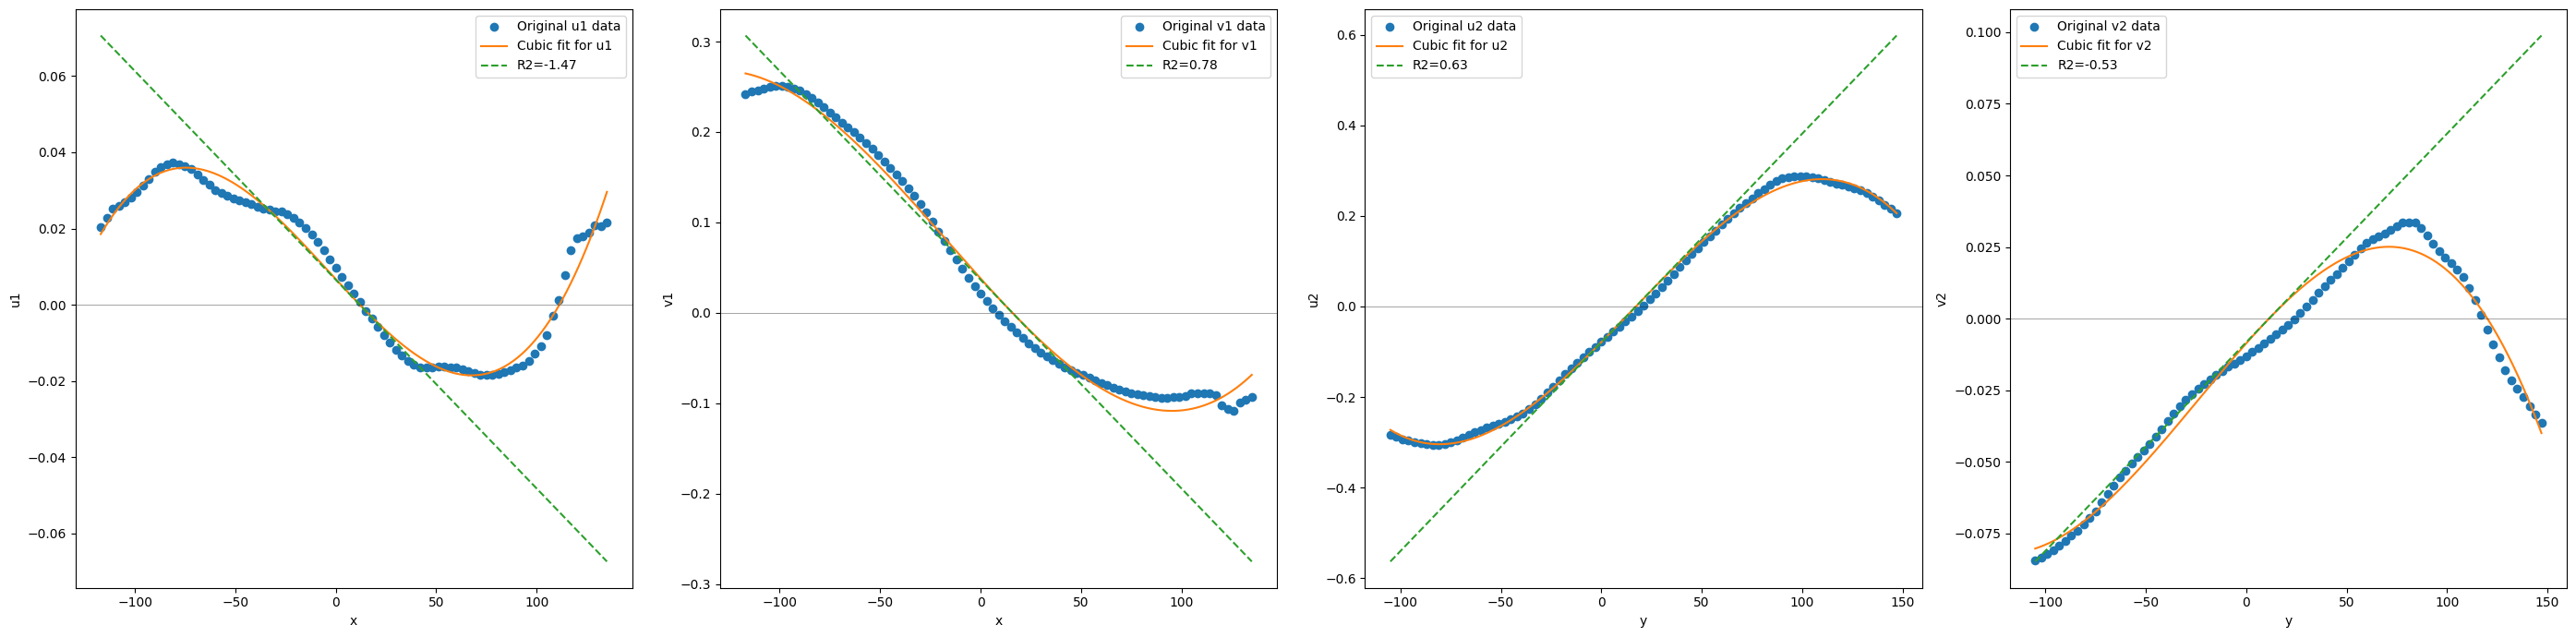

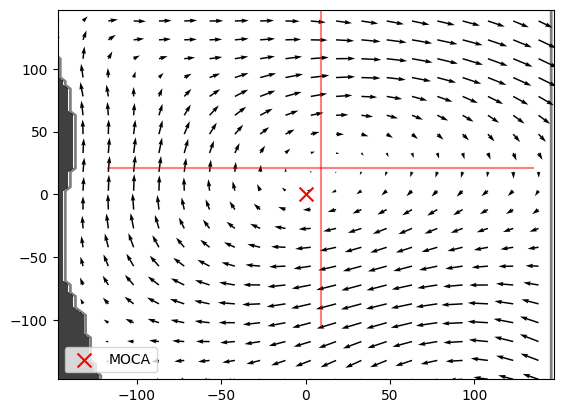

In [15]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 20

vis(eddy, t, depth_lvl)

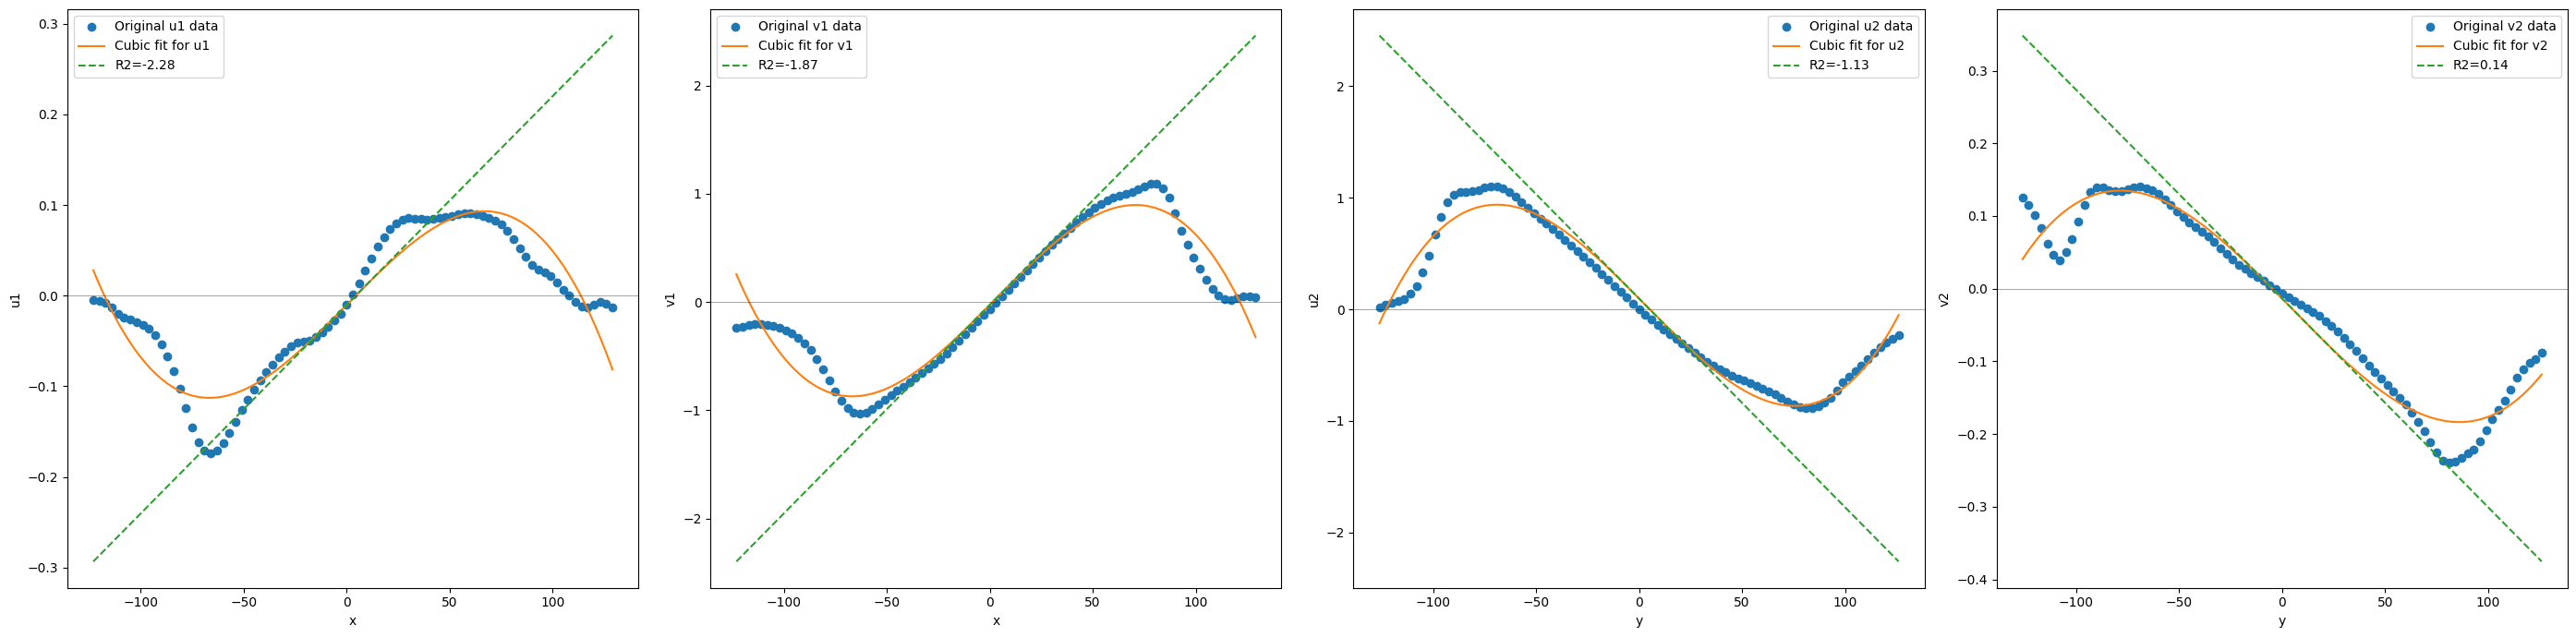

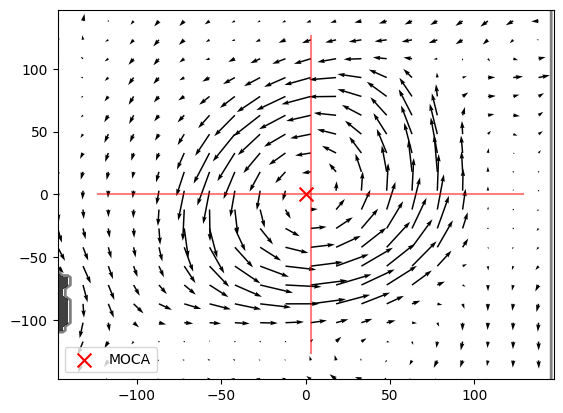

In [83]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 0, 7

vis(eddy, t, depth_lvl)

In [68]:
result_data = pd.DataFrame(columns=['Eddy', 'Day', 'z', 'nxc', 'nyc', 'xc', 'yc', 'Depth', 'Vort'])

for eddy in the_frontier_eddies:
    
    for t in range(30):
    
        U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
        X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
        var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
        xc_pre, yc_pre = 0, 0

        for depth_lvl in range(U.shape[-1]):

            # Find nencioli
            u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
            neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
            neddy = neddy[neddy[:, 2] == var]
            
            if len(neddy[:, 1]) > 1:
                R = np.hypot(neddy[:, 1], neddy[:, 0]) if depth_lvl == 0 else np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
                neddy = neddy[R == np.nanmin(R)]
            elif len(neddy[:, 1]) == 0:
                break
            
            nxc, nyc = neddy[0, 1], neddy[0, 0]
            nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
            
            # Fit cubic and tangent
            def fit_cubic_and_tangent(x, y):
                cubic = np.poly1d(np.polyfit(x, y, 3))
                cubic_deriv = np.polyder(cubic)
                roots = np.roots(cubic)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    slope = cubic_deriv(root)
                    intercept = -slope * root
                else:
                    slope = 0
                    roots = np.roots(cubic_deriv)
                    valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                    if valid_roots.size:
                        R = np.abs(valid_roots-x[len(x)//2])
                        root = valid_roots[R==np.min(R)]
                        intercept = cubic(root)
                    else:
                        intercept = np.mean(y)
            
                tangent_line = slope * x + intercept
                sst = np.sum((y - np.mean(y))**2)
                sse = np.sum((y - tangent_line)**2)
                r_squared = 1 - (sse / sst)
            
                return slope, intercept, r_squared
            
            # Plot fits
            def extend_indices(arr, start_idx, r):
                indices = [start_idx]
                idx = start_idx
                i = 0
                while idx > 0 and not np.isnan(arr[idx - 1]):
                    idx -= 1
                    indices.insert(0, idx)
                    if i > r:
                        break
                    i += 1
                idx = start_idx
                i = 0
                while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
                    idx += 1
                    indices.append(idx)
                    if i > r:
                        break
                    i += 1
                return indices
            
            r = 40 # 
            indices_1 = extend_indices(u[:, njc], nic, r)
            indices_2 = extend_indices(u[nic, :], njc, r)
            u1 = u[indices_1, njc]
            v1 = v[indices_1, njc]
            u2 = u[nic, indices_2]
            v2 = v[nic, indices_2]
            xx = x[indices_1] / 1000
            yy = y[indices_2] / 1000
                        
            # Calculate results
            A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
            B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
            C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
            D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
            
            alpha = A0 if r2A < r2B else C0
            beta = B0 if r2B < r2D else D0
            gamma = A1 if r2A < r2D else -D1
            q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                        
            yc = ((q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2)))[0]
            xc = ((alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22)))[0]
            w = (2 * (q11 + q22))[0]

            xc_pre, yc_pre = xc, yc

            VORT_THRESH = 0.006
            R = np.hypot(xc - xc_pre, yc - yc_pre)
            if np.abs(w) > VORT_THRESH and R < 100000:

                result_data.loc[len(result_data)] = {
                    'Eddy': eddy,
                    'Day': t,
                    'z': depth_lvl,
                    'nxc': nxc/1000,
                    'nyc': nyc/1000,
                    'xc': xc,
                    'yc': yc,
                    'Depth': z_r[150, 150, depth_lvl],
                    'Vort': w
                }
            else:
                break
            

In [69]:
result_data

,Eddy,Day,z,nxc,nyc,xc,yc,Depth,Vort
0,Eddy790,0,0,6.0,0.0,5.705715,-1.480060,-1.783320,0.038041
1,Eddy790,0,1,6.0,0.0,4.883438,-0.568057,-5.879627,0.037934
2,Eddy790,0,2,6.0,0.0,4.345277,-0.169701,-10.725783,0.037865
3,Eddy790,0,3,6.0,0.0,3.793930,0.039456,-16.383097,0.037828
4,Eddy790,0,4,3.0,0.0,2.236786,0.074891,-22.925581,0.037853
...,...,...,...,...,...,...,...,...,...
2614,Eddy775,29,16,6.0,-3.0,-0.751283,0.541950,-266.206398,-0.010025
2615,Eddy775,29,17,6.0,-3.0,-0.762806,0.469644,-327.440851,-0.009005
2616,Eddy775,29,18,9.0,-3.0,-0.212353,0.263835,-407.922192,-0.008040
2617,Eddy775,29,19,9.0,-3.0,-0.379914,0.587212,-515.416489,-0.007157


In [70]:
t = 0
filtered_data = result_data[(result_data['Eddy'] == 'Eddy790') & (result_data['Day'] == t)]
filtered_data


,Eddy,Day,z,nxc,nyc,xc,yc,Depth,Vort
0,Eddy790,0,0,6.0,0.0,5.705715,-1.480060,-1.783320,0.038041
1,Eddy790,0,1,6.0,0.0,4.883438,-0.568057,-5.879627,0.037934
2,Eddy790,0,2,6.0,0.0,4.345277,-0.169701,-10.725783,0.037865
3,Eddy790,0,3,6.0,0.0,3.793930,0.039456,-16.383097,0.037828
4,Eddy790,0,4,3.0,0.0,2.236786,0.074891,-22.925581,0.037853
5,Eddy790,0,5,3.0,0.0,1.747343,-0.079914,-30.444118,0.037907
6,Eddy790,0,6,3.0,0.0,1.459157,-0.266404,-39.052712,0.037952
7,Eddy790,0,7,3.0,0.0,1.290012,-0.380013,-48.897638,0.037988
8,Eddy790,0,8,3.0,0.0,1.228805,-0.499251,-60.170639,0.037874
9,Eddy790,0,9,3.0,0.0,1.009368,-0.688434,-73.127842,0.037725


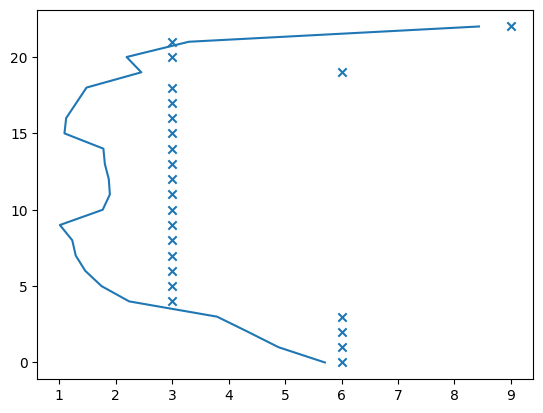

In [79]:
plt.scatter(filtered_data['nxc'], filtered_data['z'], marker='x')
plt.plot(filtered_data['xc'], filtered_data['z'])

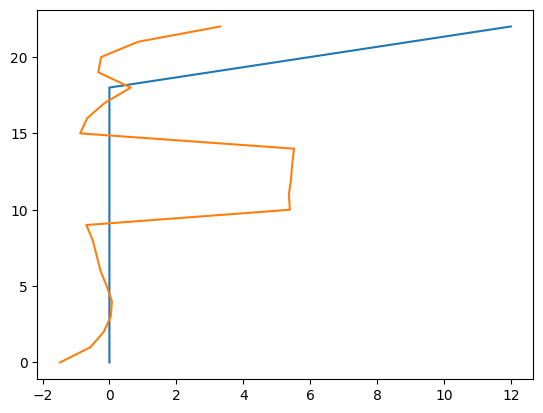

In [80]:
plt.plot(filtered_data['nyc'], filtered_data['z'])
plt.plot(filtered_data['yc'], filtered_data['z'])

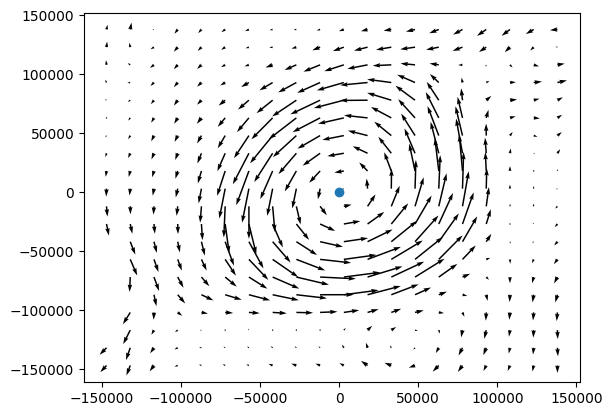

In [82]:
U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']

depth_lvl = 11
u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

data = filtered_data.loc[filtered_data['z']==depth_lvl]

spacing = 5
plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)
plt.scatter(data['xc'], data['yc'])